Task 01

In [1]:
import pandas as pd
import gzip
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# --- 1. SETUP PATHS AND LOADING FUNCTIONS ---
# This is the exact path to your file
FILE_PATH = r"D:\1.Lihansa\Intern\Elevvo\Appliances.jsonl.gz"

def parse(path):
    """Generator to read the gzipped JSONL file line by line."""
    with gzip.open(path, 'rb') as g:
        for l in g:
            yield json.loads(l)

def get_df(path, num_samples=50000):
    """Converts JSON lines into a Pandas DataFrame with progress updates."""
    i = 0
    df_dict = {}
    print(f"📂 Attempting to open: {path}")
    
    try:
        for d in parse(path):
            df_dict[i] = d
            i += 1
            if i % 10000 == 0:
                print(f"📝 Progress: Loaded {i} reviews...")
            if i == num_samples:
                break
        
        print(f"✅ Successfully loaded {i} reviews.")
        return pd.DataFrame.from_dict(df_dict, orient='index')
    
    except FileNotFoundError:
        print(f"❌ ERROR: Could not find the file at {path}")
        return None

# --- 2. EXECUTION START ---

# Check if file exists before starting
if os.path.exists(FILE_PATH):
    # Load data
    df = get_df(FILE_PATH)
    
    if df is not None:
        # Preprocessing: Keep only text and rating
        # In the 2023 dataset, the columns are usually 'text' and 'rating'
        df = df[['text', 'rating']].dropna(subset=['text'])

        # Filter out 3-star reviews and create binary sentiment
        df = df[df['rating'] != 3]
        df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)
        
        print(f"✅ Preprocessing complete. Final dataset size: {len(df)} samples.")

        # --- 3. VECTORIZATION ---
        print("🧮 Converting text to numbers (TF-IDF Vectorization)...")
        tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
        X = tfidf.fit_transform(df['text'])
        y = df['sentiment']

        # Split Data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # --- 4. MODEL TRAINING ---
        print("🚀 Training Logistic Regression...")
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)
        lr_pred = lr.predict(X_test)

        print("🚀 Training Naive Bayes...")
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        nb_pred = nb.predict(X_test)

        # --- 5. RESULTS ---
        print("\n" + "="*30)
        print("FINAL RESULTS")
        print("="*30)
        print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.2f}")
        print(f"Naive Bayes Accuracy:         {accuracy_score(y_test, nb_pred):.2f}")
        print("\nDetailed Report (Logistic Regression):")
        print(classification_report(y_test, lr_pred))
else:
    print(f"❌ ERROR: The path '{FILE_PATH}' does not exist. Please check your D: drive.")


📂 Attempting to open: D:\1.Lihansa\Intern\Elevvo\Appliances.jsonl.gz
📝 Progress: Loaded 10000 reviews...
📝 Progress: Loaded 20000 reviews...
📝 Progress: Loaded 30000 reviews...
📝 Progress: Loaded 40000 reviews...
📝 Progress: Loaded 50000 reviews...
✅ Successfully loaded 50000 reviews.
✅ Preprocessing complete. Final dataset size: 47260 samples.
🧮 Converting text to numbers (TF-IDF Vectorization)...
🚀 Training Logistic Regression...
🚀 Training Naive Bayes...

FINAL RESULTS
Logistic Regression Accuracy: 0.92
Naive Bayes Accuracy:         0.90

Detailed Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.43      0.57      1118
           1       0.93      0.99      0.96      8334

    accuracy                           0.92      9452
   macro avg       0.88      0.71      0.76      9452
weighted avg       0.92      0.92      0.91      9452



Visualize the most frequent positive and negative words

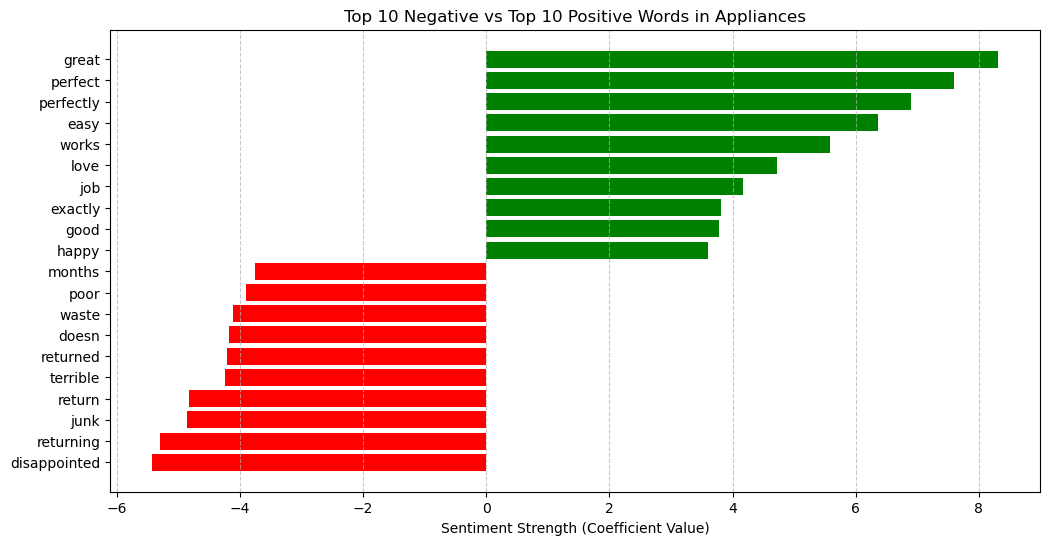

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract feature names and coefficients
feature_names = np.array(tfidf.get_feature_names_out())
# Logistic Regression coefficients (higher = positive, lower = negative)
coefs = lr.coef_.flatten()

# 2. Get indices of the top 10 negative and top 10 positive words
top_neg_indices = np.argsort(coefs)[:10]
top_pos_indices = np.argsort(coefs)[-10:]

# 3. Combine them for plotting
top_indices = np.concatenate([top_neg_indices, top_pos_indices])
top_words = feature_names[top_indices]
top_coefs = coefs[top_indices]

# 4. Create the plot
plt.figure(figsize=(12, 6))
colors = ['red' if c < 0 else 'green' for c in top_coefs]
plt.barh(top_words, top_coefs, color=colors)
plt.xlabel('Sentiment Strength (Coefficient Value)')
plt.title('Top 10 Negative vs Top 10 Positive Words in Appliances')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Compared two different mathematical approaches (Linear vs. Probabilistic)

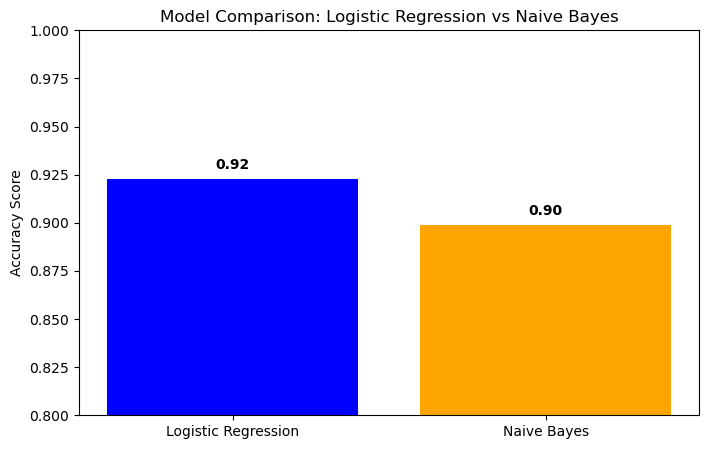

In [3]:
models = ['Logistic Regression', 'Naive Bayes']
accuracies = [accuracy_score(y_test, lr_pred), accuracy_score(y_test, nb_pred)]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0.8, 1.0) # Zoom in to see the difference clearly
plt.ylabel('Accuracy Score')
plt.title('Model Comparison: Logistic Regression vs Naive Bayes')

# Adding the exact numbers on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

Predicting Custom Sentences

In [4]:
def predict_sentiment(user_review):
    # 1. Transform the input string using the ALREADY trained tfidf
    review_vector = tfidf.transform([user_review])
    
    # 2. Use the trained Logistic Regression model to predict
    prediction = lr.predict(review_vector)[0]
    
    # 3. Get the probability (confidence) score
    probability = lr.predict_proba(review_vector)
    confidence = np.max(probability) * 100
    
    # 4. Format the output
    sentiment = "POSITIVE 😊" if prediction == 1 else "NEGATIVE 💢"
    
    print(f"Review: '{user_review}'")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print("-" * 30)

# --- TEST IT OUT ---
predict_sentiment("This fridge is too loud and the ice maker broke after a week.")
predict_sentiment("Absolutely amazing dishwasher, it is so quiet and cleans perfectly!")
predict_sentiment("It is okay, but the installation was a nightmare.")

Review: 'This fridge is too loud and the ice maker broke after a week.'
Predicted Sentiment: NEGATIVE 💢
Confidence: 75.59%
------------------------------
Review: 'Absolutely amazing dishwasher, it is so quiet and cleans perfectly!'
Predicted Sentiment: POSITIVE 😊
Confidence: 99.74%
------------------------------
Review: 'It is okay, but the installation was a nightmare.'
Predicted Sentiment: POSITIVE 😊
Confidence: 77.19%
------------------------------


Saving The Model

In [5]:
import joblib

# Save the model and the vectorizer to your folder
joblib.dump(lr, 'sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("💾 Model saved successfully! You can now use these files in any Python script.")

💾 Model saved successfully! You can now use these files in any Python script.
